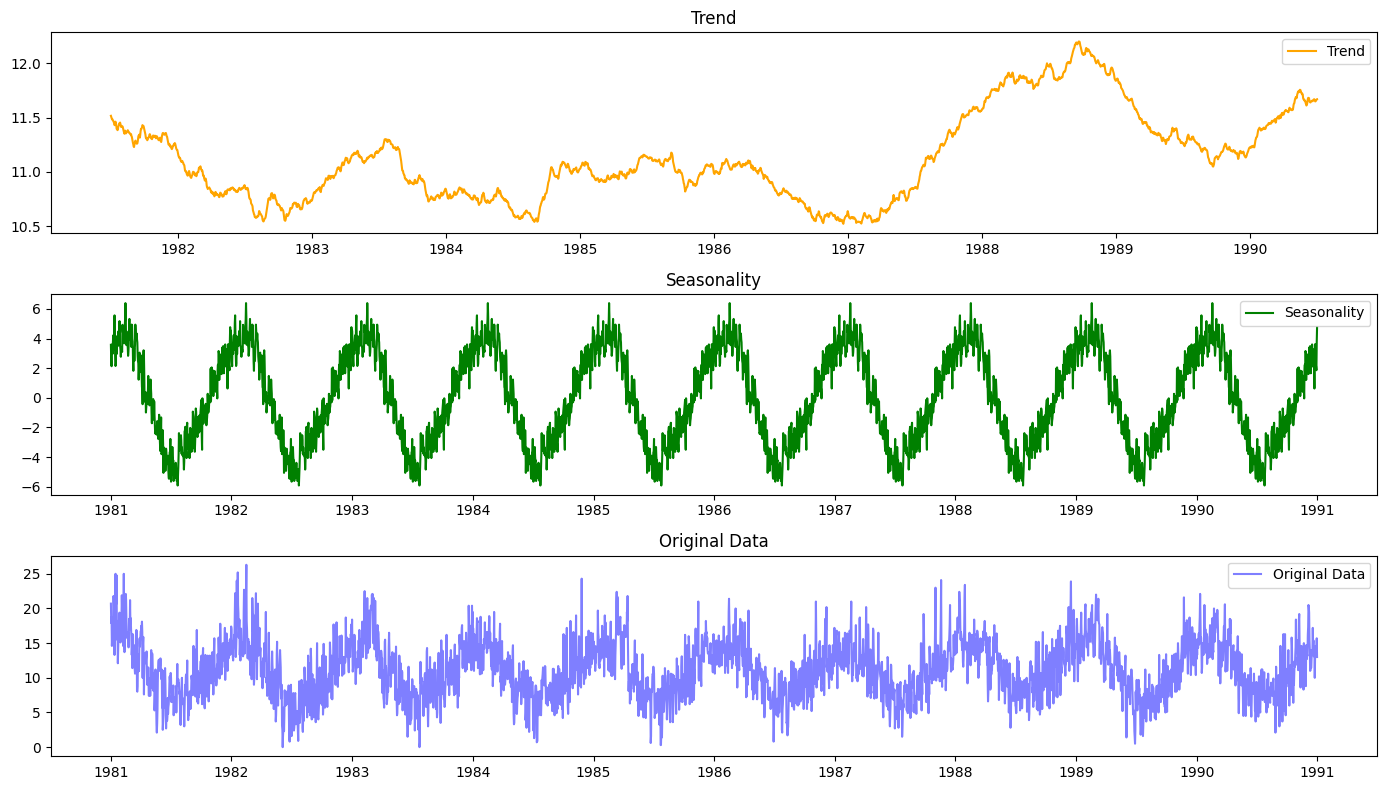

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the dataset
df = pd.read_csv("daily-minimum-temperatures-in-me.csv")

# Rename and clean columns
df.columns = ['Date', 'Temperature']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Remove any invalid temperature values
df = df[df['Temperature'].str.match(r'^-?\d+(\.\d+)?$', na=False)]
df['Temperature'] = df['Temperature'].astype(float)

# Decompose the time series (using additive model and yearly seasonality)
decomposition = seasonal_decompose(df['Temperature'], model='additive', period=365)

# Plot the components
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.title('Trend')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.title('Seasonality')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df['Temperature'], label='Original Data', alpha=0.5, color='blue')
plt.title('Original Data')
plt.legend()

plt.tight_layout()
plt.show()


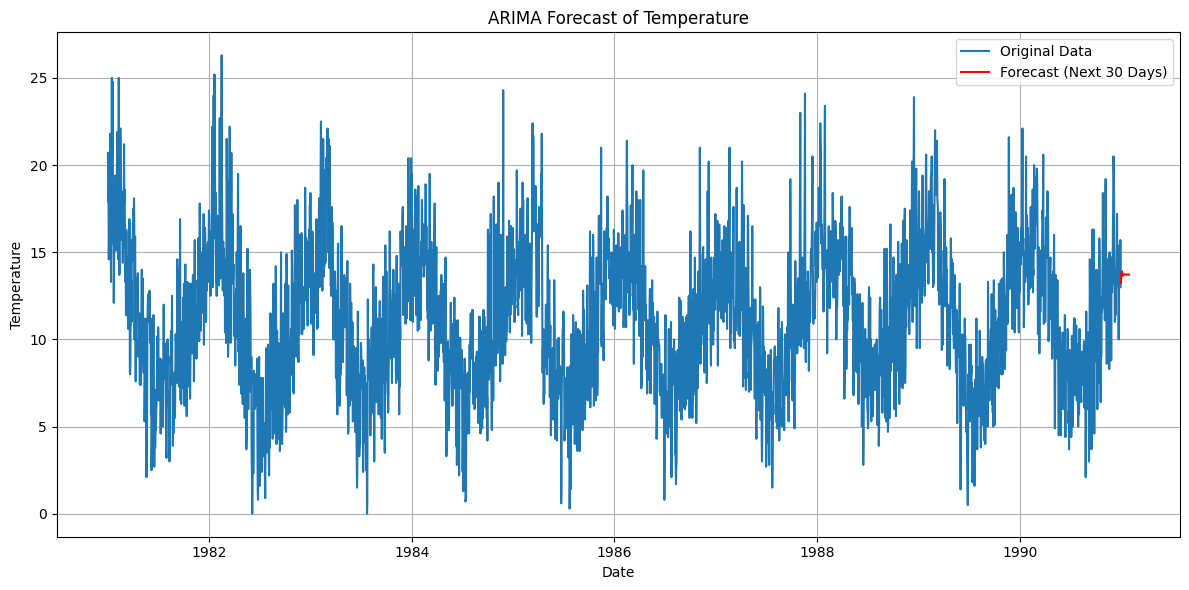

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv("daily-minimum-temperatures-in-me.csv")
df.columns = ['Date', 'Temperature']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Remove invalid temperature entries and convert to float
df = df[df['Temperature'].str.match(r'^-?\d+(\.\d+)?$', na=False)]
df['Temperature'] = df['Temperature'].astype(float)

# Fit the ARIMA model
model = ARIMA(df['Temperature'], order=(5, 1, 0))  # You can tweak the (p,d,q) values
model_fit = model.fit()

# Forecast the next 30 days
forecast = model_fit.forecast(steps=30)

# Plot original data and forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Temperature'], label='Original Data')
plt.plot(pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30, freq='D'),
         forecast, label='Forecast (Next 30 Days)', color='red')
plt.title('ARIMA Forecast of Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.0441
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0117
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0107
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.0103
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0104
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0105
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0105
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0096
Epoch 9/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0098
Epoch 10/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0093
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━

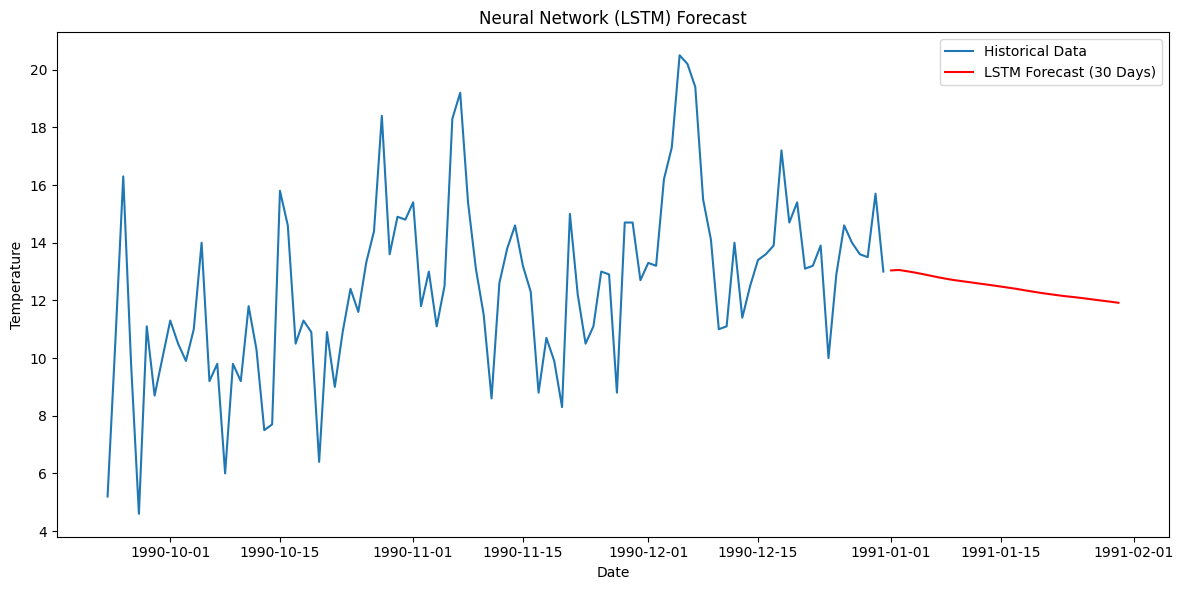

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Load and prepare the data
df = pd.read_csv("daily-minimum-temperatures-in-me.csv")
df.columns = ['Date', 'Temperature']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[df['Temperature'].str.match(r'^-?\d+(\.\d+)?$', na=False)]
df['Temperature'] = df['Temperature'].astype(float)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df['Temperature'].values.reshape(-1, 1))

# Prepare the dataset for LSTM
def create_dataset(data, look_back=30):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 30
X, y = create_dataset(scaled_data, look_back)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into train and test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)

# Forecast the next 30 values
last_30_days = scaled_data[-look_back:]
forecast_input = last_30_days.reshape(1, look_back, 1)
forecast = []

for _ in range(30):
    pred = model.predict(forecast_input)[0]
    forecast.append(pred)
    forecast_input = np.append(forecast_input[:, 1:, :], [[pred]], axis=1)

forecast = scaler.inverse_transform(forecast)

# Plot
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100:], df['Temperature'][-100:], label='Historical Data')
plt.plot(forecast_dates, forecast, label='LSTM Forecast (30 Days)', color='red')
plt.legend()
plt.title("Neural Network (LSTM) Forecast")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.tight_layout()
plt.show()


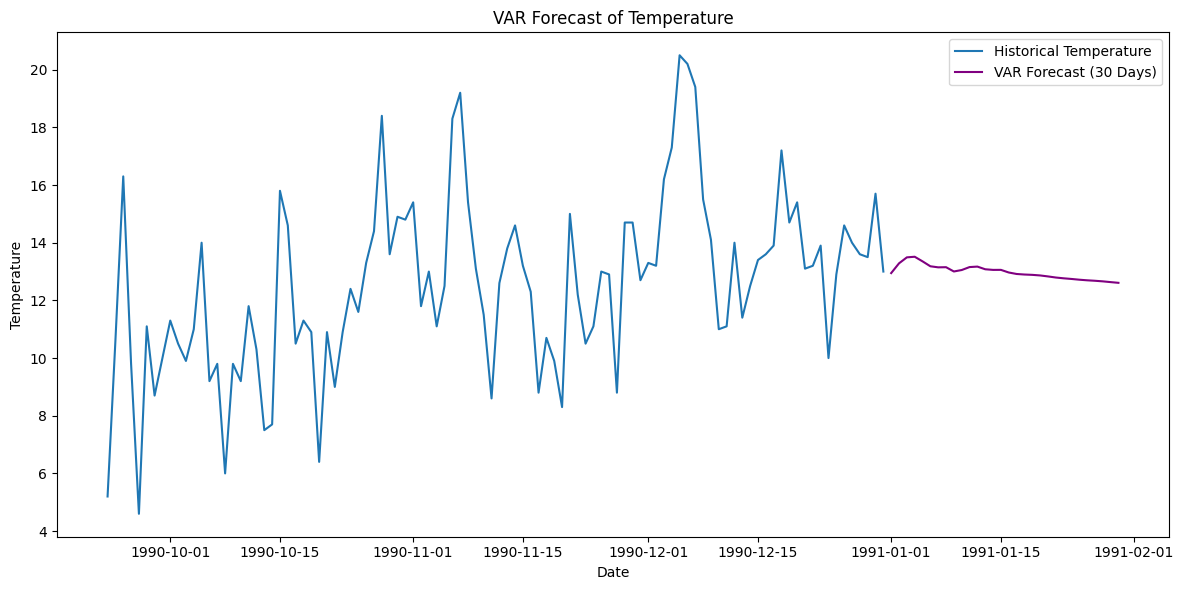

In [4]:
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler

# Prepare multivariate dataset (Temperature + Lagged Temperature)
data = df.copy()
data['Lagged'] = data['Temperature'].shift(1)
data.dropna(inplace=True)

# Standardize the data
scaler = StandardScaler()
scaled = scaler.fit_transform(data)

# Convert to DataFrame
scaled_df = pd.DataFrame(scaled, index=data.index, columns=data.columns)

# Fit VAR model
model = VAR(scaled_df)
results = model.fit(15)

# Forecast next 30 days
forecast_input = scaled_df.values[-15:]
forecast = results.forecast(y=forecast_input, steps=30)

# Inverse transform
forecast_df = pd.DataFrame(forecast, columns=scaled_df.columns)
forecast_original = scaler.inverse_transform(forecast_df)

# Plot Temperature Forecast
forecast_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30)
plt.figure(figsize=(12, 6))
plt.plot(data.index[-100:], data['Temperature'][-100:], label='Historical Temperature')
plt.plot(forecast_dates, forecast_original[:, 0], label='VAR Forecast (30 Days)', color='purple')
plt.title("VAR Forecast of Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.tight_layout()
plt.show()
